<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercises</a></span><ul class="toc-item"><li><span><a href="#Dice" data-toc-modified-id="Dice-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dice</a></span><ul class="toc-item"><li><span><a href="#Exercise-1" data-toc-modified-id="Exercise-1-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Exercise 1</a></span></li><li><span><a href="#Exercise-2" data-toc-modified-id="Exercise-2-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Exercise 2</a></span></li></ul></li><li><span><a href="#Bonus-Exercise" data-toc-modified-id="Bonus-Exercise-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Bonus Exercise</a></span></li><li><span><a href="#The-Cookie-Problem" data-toc-modified-id="The-Cookie-Problem-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>The Cookie Problem</a></span></li><li><span><a href="#Exercise-3" data-toc-modified-id="Exercise-3-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Exercise 3</a></span></li></ul></li></ul></div>

# Introduction

This notebook contains solutions to the exercises in the [cookie notebook](https://github.com/AllenDowney/BayesMadeSimple/blob/master/01_cookie_soln.ipynb).

# Libraries

In [1]:
using Gen
using Statistics
using Plots
using DataStructures
using Printf

┌ Info: Precompiling Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1242
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242


# Exercises

## Dice

Define a model that sums a $n$ throws of a two 6-sided dice:

In [2]:
@gen function sum_two_dice(n::Any)
    dice1 = @trace(uniform_discrete(1, 6), :dice1)
    dice2 = @trace(uniform_discrete(1, 6), :dice2)
   
    total = @trace(normal(dice1 + dice2, 0), :total)
end;

### Exercise 1

Plot the pmf of `sum_two_dice` and compute its mean:

In [3]:
function run_simulation(trials::Integer)::Array{Integer, 1}
    totals = []
    
    for i in 1:trials
        trace = Gen.simulate(sum_two_dice, (nothing,))
        total = trace[:total]
        push!(totals, total)
    end
    
    return totals
end

trials = 100000
results = run_simulation(trials);

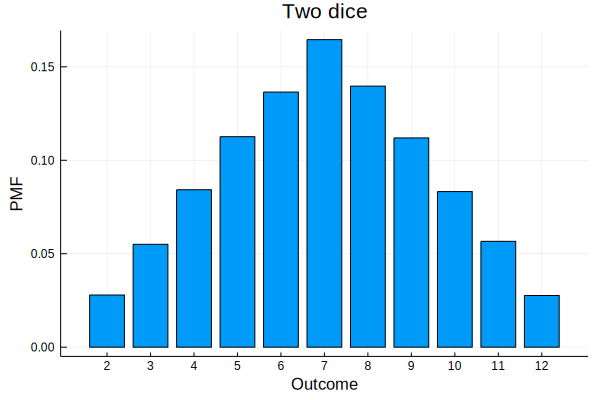

In [4]:
c = counter(results)
xs = collect(keys(c))

ys = collect(values(c))
ys = ys ./ sum(ys)

bar(xs, ys, xaxis=xs, label="", xlabel="Outcome", ylabel="PMF", title="Two dice")

In [5]:
m = mean(results)

println(@sprintf "The mean of the pmf is %.2f" m)

The mean of the pmf is 7.00


### Exercise 2

Suppose I roll two dice and tell you the result is greater than 3.

Plot the Pmf of the remaining possible outcomes and compute its mean.

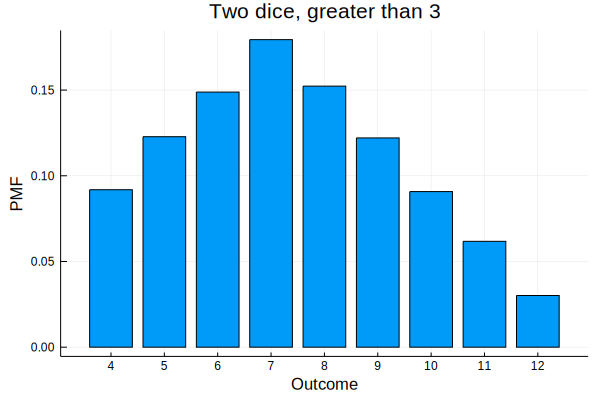

In [6]:
new_results = filter(x -> x > 3, results)

c = counter(new_results)
xs = collect(keys(c))

ys = collect(values(c))
ys = ys ./ sum(ys)

bar(xs, ys, xaxis=xs, label="", xlabel="Outcome", ylabel="PMF", title="Two dice, greater than 3")

In [7]:
m = mean(new_results)

@sprintf "The mean of the pmf is %.2f" m

"The mean of the pmf is 7.40"

## Bonus Exercise

**Question**

In Dungeons and Dragons, the amount of damage a goblin can withstand is the sum of two six-sided dice. The amount of damage you inflict with a short sword is determined by rolling one six-sided die.

Suppose you are fighting a goblin and you have already inflicted 3 points of damage. What is your probability of defeating the goblin with your next successful attack?

**Solution**

Define a model to model the problem:

In [8]:
@gen function attack_goblin(prev_damage::Integer)
    dice1 = uniform_discrete(1, 6)
    dice2 = uniform_discrete(1, 6)
    goblin_health = @trace(normal(dice1 + dice2, 0), :goblin_health)
    
    current_damage = uniform_discrete(1, 6)
    total_damage = @trace(normal(current_damage + prev_damage, 0), :total_damage)
end;

Simulate the problem:

In [9]:
function run_simulation(trials::Integer)
    outcomes = []
    
    for _ in 1:trials
        trace = Gen.simulate(attack_goblin, (3,))
        is_dead_goblin = trace[:total_damage] >= trace[:goblin_health] ? 1 : 0
        push!(outcomes, is_dead_goblin)        
    end
    
    return outcomes
end

results = run_simulation(100000);

In [10]:
@sprintf "The probability of defeating the goblin in the next successful attack is %.2f" mean(results)

"The probability of defeating the goblin in the next successful attack is 0.50"

**Alternative Solution**

Define the model:

In [11]:
@gen function attack_goblin(x::Any)
    dice1 = uniform_discrete(1, 6)
    dice2 = uniform_discrete(1, 6)
    goblin_health = @trace(normal(dice1 + dice2, 0), :goblin_health)
    
    prev_damage = @trace(uniform_discrete(1, 6), :prev_damage)
    current_damage = uniform_discrete(1, 6)
    total_damage = @trace(normal(current_damage + prev_damage, 0), :total_damage)
end;

Sample from the posterior:

In [12]:
 outcomes = []
 observations = Gen.choicemap(:prev_damage => 3)   

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(attack_goblin, (nothing,), observations, 100)
    is_dead_goblin = trace[:total_damage] >= trace[:goblin_health] ? 1 : 0
    push!(outcomes, is_dead_goblin)        
end

Compute the probability:

In [13]:
@sprintf "The probability of defeating the goblin in the next successful attack is %.2f" mean(outcomes)

"The probability of defeating the goblin in the next successful attack is 0.50"

## The Cookie Problem

**Question**

Suppose there are two bowls of cookies.

Bowl #1 has 10 chocolate and 30 vanilla

Bowl #2 has 20 each

Fred picks a bowl at random, and then picks a cookie at random.
The cookie turns out to be vanilla.

What is the probability that Fred picked from Bowl #1?

**Solution**

Model the problem:

In [14]:
int_to_cookie = Dict(1 => "chocolate", 2 => "vanilla")

cookie_to_int = Dict()

for (cookie_str, cookie_num) in int_to_cookie
    cookie_to_int[cookie_num] = cookie_str
end

In [15]:
@gen function pick_bowl_cookie(num_cookies::Integer)
    
    bowl_num = @trace(categorical([0.5, 0.5]), (:bowl_num, 1))
    
    for i in 1:num_cookies
        cookie_probs = (bowl_num == 1) ? [0.25, 0.75] : [0.5, 0.5]
        @trace(categorical(cookie_probs), (:cookie,i))
    end

end;

Sample from the posterior:

In [16]:
outcomes = []
observations = Gen.choicemap((:cookie, 1) => cookie_to_int["vanilla"])

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(pick_bowl_cookie, (1, ), observations, 100)
    outcome = trace[(:bowl_num, 1)] == 1
    push!(outcomes, outcome)
end


Compute the probability:

In [17]:
@sprintf "The probability that Fred picked from Bowl #1 is %.2f " mean(outcomes)

"The probability that Fred picked from Bowl #1 is 0.60 "

## Exercise 3

**Question** 

Suppose we put the first cookie back, stir, choose again from the same bowl, and get a chocolate cookie.

What are the posterior probabilities after the second cookie?

**Solution**

We just need to update the `observations`:

In [18]:
outcomes = []
observations = Gen.choicemap((:cookie, 1) => cookie_to_int["vanilla"], 
                             (:cookie, 2) => cookie_to_int["chocolate"])

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(pick_bowl_cookie, (2, ), observations, 100)
    outcome = trace[(:bowl_num, 1)] == 1
    push!(outcomes, outcome)
end

In [19]:
@sprintf "The probability that Fred picked from Bowl #1 is %.2f " mean(outcomes)

"The probability that Fred picked from Bowl #1 is 0.43 "

Note that the order of the draws does not matter:

In [20]:
outcomes = []
observations = Gen.choicemap((:cookie, 1) => cookie_to_int["chocolate"], 
                             (:cookie, 2) => cookie_to_int["vanilla"])

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(pick_bowl_cookie, (2, ), observations, 100)
    outcome = trace[(:bowl_num, 1)] == 1
    push!(outcomes, outcome)
end

@sprintf "The probability that Fred picked from Bowl #1 is %.2f " mean(outcomes)

"The probability that Fred picked from Bowl #1 is 0.43 "